In [31]:
import numpy as np
import pandas as pd

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [34]:
from sklearn import set_config
set_config(display='diagram')

In [35]:
train = pd.read_csv('../dataset/train_unprocessed.csv')
test = pd.read_csv('../dataset/test.csv')

In [36]:
X_train = train.drop(columns=['Id', 'SalePrice'])
Y_train = train['SalePrice']
X_test = test.drop(columns=['Id'])

In [37]:
X_train = X_train.drop(columns=['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 'MasVnrArea', 'BsmtCond', 'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'Electrical', '2ndFlrSF', 'LowQualFinSF', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'SaleType', 'SaleCondition', 'MiscFeature', 'MSSubClass', 'KitchenAbvGr', 'MoSold', 'YrSold', 'LotConfig', 'BldgType'])

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [41]:
X_train.head()

,MSZoning,LotFrontage,LotArea,Alley,LotShape,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,...,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,Fence
254,RL,70.0,8400,NaN,Reg,NAmes,1Story,5,6,1957,...,3,TA,5,0,NaN,Attchd,RFn,1,294,NaN
1066,RL,59.0,7837,NaN,IR1,Gilbert,2Story,6,7,1993,...,3,TA,7,1,TA,Attchd,RFn,2,380,NaN
638,RL,67.0,8777,NaN,Reg,Edwards,1Story,5,7,1910,...,2,TA,4,0,NaN,NaN,NaN,0,0,MnPrv
799,RL,60.0,7200,NaN,Reg,SWISU,1.5Fin,5,7,1937,...,3,Gd,7,2,TA,Detchd,Unf,1,240,MnPrv
380,RL,50.0,5000,Pave,Reg,SWISU,1.5Fin,5,6,1924,...,3,Gd,6,1,Gd,Detchd,Unf,1,308,NaN


In [42]:
Y_train.sample(5)

876    132250
366    159000
723    135000
638     85000
495     34900
Name: SalePrice, dtype: int64

In [43]:
def replace_rare_categories(df):
    df = df.copy()

    df.iloc[:, 0] = np.where(df.iloc[:, 0].isin(['FV', 'RH', 'C (all)']), 'Others', df.iloc[:, 0])  
    df.iloc[:, 3] = np.where(df.iloc[:, 3].isna() | (df.iloc[:, 3] == ''), 'None', df.iloc[:, 3])
    df.iloc[:, 3] = np.where(df.iloc[:, 3].isin(['Grvl', 'Pave']), 'Others', df.iloc[:, 3])  
    df.iloc[:, 6] = np.where(df.iloc[:, 6].isin(['SLvl', 'SFoyer', '1.5Unf', '2.5Unf', '2.5Fin']), 'Others', df.iloc[:, 6])  
    df.iloc[:, 11] = np.where(df.iloc[:, 11].isin(['Flat', 'Gambrel', 'Mansard']), 'Others', df.iloc[:, 11])  
    df.iloc[:, 12] = np.where(df.iloc[:, 12].isin(['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'ImStucc', 'Other', 'PreCast', 'Stone', 'Stucco', 'WdShing']), 'Others', df.iloc[:, 12])  
    df.iloc[:, 13] = np.where(df.iloc[:, 13].isin(['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'ImStucc', 'Other', 'PreCast', 'Stone', 'Stucco', 'WdShing']), 'Others', df.iloc[:, 13])  
    df.iloc[:, 17] = np.where(df.iloc[:, 17].isin(['Slab', 'Stone']), 'Others', df.iloc[:, 17])  
    df.iloc[:, 36] = np.where(df.iloc[:, 36].isna() | (df.iloc[:, 36] == ''), 'None', df.iloc[:, 36]) 
    df.iloc[:, 36] = np.where(df.iloc[:, 36].isin(['Basement', 'CarPort']), 'Others', df.iloc[:, 36])  

    return df


In [44]:
X_train = replace_rare_categories(X_train)
X_test = replace_rare_categories(X_test)

In [45]:
imputer_trf = ColumnTransformer(transformers=[
    ('fill_zero', SimpleImputer(strategy='constant', fill_value=0), ['LotFrontage']),
    ('fill_none', SimpleImputer(strategy='constant', fill_value='None'), [3, 14, 18, 19, 20, 35, 36, 37, 40])
], remainder='passthrough')

In [46]:
encoder_trf = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[
            ['IR3', 'IR2', 'IR1', 'Reg'],  # LotShape
            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # ExterQual
            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # ExterCond
            ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # BsmtQual
            ['No', 'Mn', 'Av', 'Gd'],  # BsmtExposure
            ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],  # BsmtFinType1
            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # HeatingQC
            ['N', 'Y'],  # CentralAir
            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # KitchenQual
            ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # FireplaceQu
            ['None', 'Unf', 'RFn', 'Fin']  # GarageFinish
        ], dtype=int, handle_unknown='use_encoded_value', unknown_value=-1), [
            12, 22, 23, 3, 4, 5, 28, 29, 36, 6, 8
        ]),
        
        ('onehot', OneHotEncoder(drop='first', sparse=False, dtype=int, handle_unknown='ignore'), [
            10, 1, 13, 14, 19, 20, 21, 2, 24, 7, 5, 9
        ])
    ],
    remainder='passthrough'
)

In [47]:
def cap_outliers(X):
    X = X.copy()
    for i in range(X.shape[1]):
        col = X[:, i]
        percentile25 = np.percentile(col, 25)
        percentile75 = np.percentile(col, 75)
        iqr = percentile75 - percentile25

        upper_limit = percentile75 + 2 * iqr
        lower_limit = percentile25 - 2 * iqr

        col = np.where(col > upper_limit, upper_limit,
                       np.where(col < lower_limit, lower_limit, col))
        X[:, i] = col
    return X

cap_outliers_trf = FunctionTransformer(cap_outliers, validate=False)


In [48]:
outlier_trf = ColumnTransformer(
    transformers=[
        ('cap_outliers', cap_outliers_trf, [80, 86, 87, 89, 98])
    ],
    remainder='passthrough'
)

In [49]:
preprocess_trf = Pipeline(steps=[
    ('imputer', imputer_trf),
    ('encoder', encoder_trf),
    ('outlier', outlier_trf)
])

In [50]:
standardize_trf = ColumnTransformer([
    ('StandardScale', StandardScaler(), slice(0, 99))
])

In [51]:
yj_trf = ColumnTransformer([
    ('yeo_johnson', PowerTransformer(), slice(0, 99))
], remainder='passthrough')


In [52]:
pca_trf = PCA(n_components=55)

In [53]:
model_trf = LinearRegression()

In [54]:
pipe = Pipeline([
    ('Preprocessor', preprocess_trf),
    ('Standardizer', standardize_trf),
    ('Yeo-Johnson', yj_trf),
    ('PCA', pca_trf),
    ('Model', model_trf)
])

In [55]:
pipe.fit(X_train, Y_train)

c:\Users\yugba\anaconda3\envs\6.86x\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('Preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('fill_zero',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['LotFrontage']),
                                                                  ('fill_none',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant'),
                                                                   [3, 14, 18,
                                                                    19, 20, 35,
                                                                    36, 37,
                                                                    40])])),
                                 ('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transf...
                                                                   FunctionTransformer(func=<function cap_outliers at 0x0000022ACB39D280>),
                                                                   [80, 86, 87,
                                                                    89,
                                                                    98])]))])),
                ('Standardizer',
                 ColumnTransformer(transformers=[('StandardScale',
                                                  StandardScaler(),
                                                  slice(0, 99, None))])),
                ('Yeo-Johnson',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('yeo_johnson',
                                                  PowerTransformer(),
                                                  slice(0, 99, None))])),
                ('PCA', PCA(n_components=55)), ('Model', LinearRegression())])

In [56]:
Y_pred = pipe.predict(X_test)

In [23]:
Y_pred = pipe.predict(X_train)

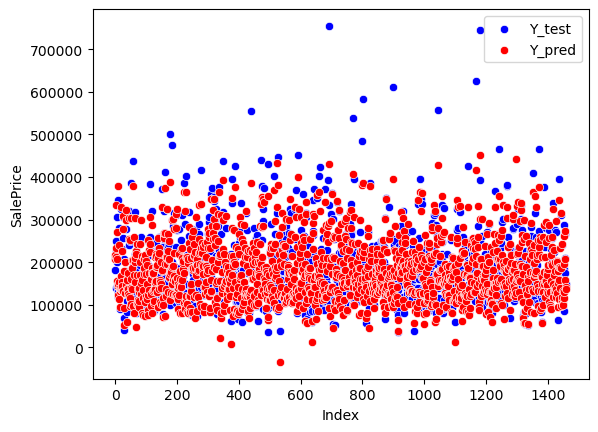

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# If Y_train is a Series or single-column DataFrame
df1 = pd.DataFrame({'Index': range(len(Y_train)), 'SalePrice': Y_train.squeeze()})  # .squeeze() handles both Series or single-column DF
df2 = pd.DataFrame({'Index': range(len(Y_pred)), 'SalePrice': Y_pred})

# Plot
sns.scatterplot(data=df1, x='Index', y='SalePrice', color='blue', label='Y_test')
sns.scatterplot(data=df2, x='Index', y='SalePrice', color='red', label='Y_pred')

plt.legend()
plt.show()


In [58]:
from sklearn.metrics import r2_score

# Predict
y_pred = pipe.predict(X_test)

# R² score
r2 = r2_score(Y_test, y_pred)

# Get n and p
n = X_test.shape[0]
p = pipe.named_steps['PCA'].n_components_  # or use transformed X_test.shape[1] if PCA not used

# Adjusted R²
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("Adjusted R²:", r2_adj)
print("R2 Score: ", r2)


Adjusted R²: 0.7898148586691154
R2 Score:  0.8295405726663616


In [26]:
import pickle
pickle.dump(pipe,open('../pipeline/pipe.pkl','wb'))

In [27]:
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': Y_pred
})

submission.to_csv('../submissions/submission.csv', index=False)